In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from time import time

H=100, W=100


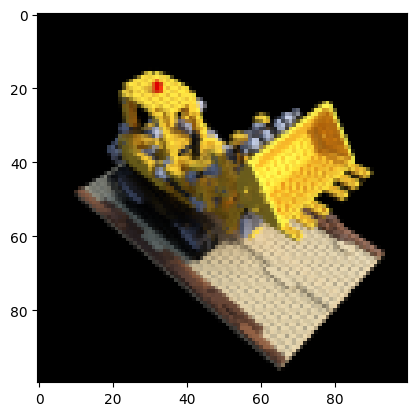

In [2]:
data = np.load("../data/tiny_nerf_data.npz")
imgs, poses, focal = data["images"], data["poses"], data["focal"]
_, H, W, _ = imgs.shape
test_img, test_pose = torch.tensor(imgs[101]), torch.tensor(poses[101])

print(f"{H=}, {W=}")
plt.imshow(test_img)

In [8]:
torch.meshgrid(torch.arange(10), torch.arange(10), indexing="xy")

(tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
         [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
         [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
         [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
         [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
         [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]]))

In [11]:
torch.arange(10).expand(10, 10), torch.arange(10).unsqueeze(-1).expand(10, 10)

(tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
         [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
         [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
         [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
         [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
         [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]]))

In [20]:
def encode_pos(x, emb_dim):
    rets = [x]
    for i in range(emb_dim):
        rets.append(torch.sin(2.**i * x))
        rets.append(torch.cos(2.**i * x))
    return torch.cat(rets, dim=0)

def get_ray_origin_dir(H, W, focal, pose):
    i, j = torch.meshgrid(torch.arange(H), torch.arange(W), indexing="xy")
    dirs = torch.stack([
        +(i - H/2) / focal,
        -(j - W/2) / focal,
        -torch.ones_like(i)
    ], dim=-1)
    ray_dirs = (dirs @ pose[:3, :3].T).permute(2, 0, 1)
    ray_origin = pose[:3, -1].view(3, 1, 1)
    return ray_origin, ray_dirs

def get_rays(H, W, focal, pose, near, far, num_samples, emb_dim):
    rayo, rayd = get_ray_origin_dir(H, W, focal, pose)
    depths = torch.linspace(near, far, num_samples).view(-1, 1, 1)
    rays = rayo + (rayd.unsqueeze(0) * depths.view(-1, 1, 1, 1))
    rays = rays.reshape(-1, H, W)
    return encode_pos(rays, emb_dim)

get_rays(H, W, focal, torch.tensor(poses[0]), 2, 6, 1, 0).shape

torch.Size([3, 100, 100])

In [33]:
torch.linspace(0, 1, 10)

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

In [44]:
h, w, f = 3, 3, 2
near, far = 2, 6
num_samples = 2
emb_dim = 1
pose = torch.tensor([
    [-9.9990219e-01,  4.1922452e-03, -1.3345719e-02, -5.3798322e-02],
    [-1.3988681e-02, -2.9965907e-01,  9.5394367e-01,  3.8454704e+00],
    [-4.6566129e-10,  9.5403719e-01,  2.9968831e-01,  1.2080823e+00],
    [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]
])

rayo, rayd = get_ray_origin_dir(h, w, f, pose)
print(rayd)
depths = torch.linspace(near, far, num_samples).view(-1, 1, 1)
rays = rayo + (rayd.unsqueeze(0) * depths.view(-1, 1, 1, 1))
rays = rays.reshape(-1, h, w)
rays = encode_pos(rays, emb_dim)
print(rays)

tensor([[[ 0.7664,  0.2665, -0.2335],
         [ 0.7643,  0.2644, -0.2356],
         [ 0.7622,  0.2623, -0.2377]],

        [[-1.1682, -1.1752, -1.1822],
         [-1.0184, -1.0254, -1.0324],
         [-0.8685, -0.8755, -0.8825]],

        [[ 0.4158,  0.4158,  0.4158],
         [-0.0612, -0.0612, -0.0612],
         [-0.5382, -0.5382, -0.5382]]])
tensor([[[ 1.4790,  0.4791, -0.5208],
         [ 1.4748,  0.4749, -0.5250],
         [ 1.4707,  0.4707, -0.5292]],

        [[ 1.5091,  1.4951,  1.4811],
         [ 1.8087,  1.7947,  1.7808],
         [ 2.1084,  2.0944,  2.0804]],

        [[ 2.0398,  2.0398,  2.0398],
         [ 1.0857,  1.0857,  1.0857],
         [ 0.1317,  0.1317,  0.1317]],

        [[ 4.5447,  1.5450, -1.4547],
         [ 4.5321,  1.5324, -1.4673],
         [ 4.5195,  1.5198, -1.4799]],

        [[-3.1637, -3.2057, -3.2476],
         [-2.2647, -2.3067, -2.3487],
         [-1.3658, -1.4077, -1.4497]],

        [[ 3.7031,  3.7031,  3.7031],
         [ 0.8410,  0.8410,  0.841

In [5]:
h = get_rays(3, 3, 1, torch.tensor(poses[0]), 0, 1, 1, 0)
h.shape, h[:, 1, 2]

(torch.Size([3, 3, 3]), tensor([-0.0538,  3.8455,  1.2081]))

In [7]:
class ResNetBlock(nn.Module):

    def __init__(self, channels, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size)
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.act = nn.ReLU()

    def forward(self, x):
        skip = x
        x = self.act(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return x + skip

class SuperResBlock(nn.Sequential):

    def __init__(self, in_channels, out_channels, num_convs):
        layers = [
            #nn.Upsample(scale_factor=2),
            #nn.Conv2d(in_channels, out_channels, 1)
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        ]
        for _ in range(num_convs):
            layers.append(ResNetBlock(out_channels, 1))
        super().__init__(*layers)

class MobileR2L(nn.Sequential):

    def __init__(self, in_channels, hidden_channels, num_layers, num_sr_modules):
        super().__init__()
        self.head = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 1), nn.ReLU()
        )
        self.body = nn.Sequential(*[
            ResNetBlock(hidden_channels, 1)
            for _ in range(num_layers)
        ])
        self.upscale = nn.Sequential(*[
            SuperResBlock(hidden_channels//(2**i), hidden_channels//(2**(i+1)), 2)
            for i in range(num_sr_modules)
        ])
        self.tail = nn.Conv2d(hidden_channels//(2**num_sr_modules), 3, 1)
    
    def forward(self, x):
        x = self.head(x)
        x = self.body(x) + x
        x = self.upscale(x)
        return self.tail(x)

with torch.no_grad():
    model = MobileR2L(21, 256, 8, 0).cuda()
    x = get_rays(H, W, focal, torch.tensor(poses[0]), 2, 6, 1, 3).unsqueeze(0).cuda()
    #%timeit model(x)
    out = model(x)
    print(out.shape)
    print(sum(p.numel() for p in model.parameters()))
    #torch.save(model, "test_tr.pt")

torch.Size([1, 3, 100, 100])
1067267


In [8]:
x.shape

torch.Size([1, 21, 100, 100])

In [9]:
torch.tensor(imgs[0]).permute(2, 0, 1).shape

torch.Size([3, 100, 100])

  0%|                          | 3/10000 [00:00<30:53,  5.39it/s, loss=2.46e-01]


KeyboardInterrupt: 

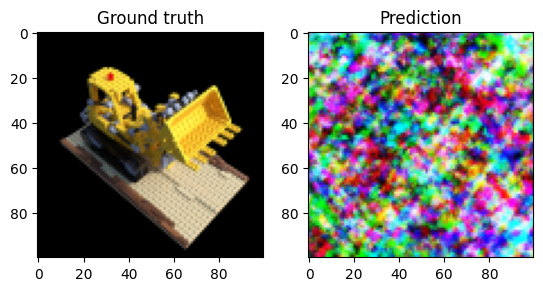

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
images_to_plot = 20

emb_dim = 6
num_samples = 16
num_iters = 10000
near, far = 2., 6.
num_images, H, W, _ = imgs.shape

model = MobileR2L(3*(emb_dim*2+1)*num_samples, 128, 16, 0).to(device)
optim = torch.optim.Adam(model.parameters(), 5e-4)
criterion = F.mse_loss

for i in (pbar := tqdm(range(num_iters), ncols=80)):
    
    index = torch.randint(0, num_images, [1])[0]
    img = torch.tensor(imgs[index]).permute(2, 0, 1).to(device)
    pose = torch.tensor(poses[index])
    
    x = get_rays(H, W, focal, pose, near, far, num_samples, emb_dim).unsqueeze(0).to(device)
    pred_img = F.sigmoid(model(x)).squeeze(0)
    loss = criterion(pred_img, img)

    optim.zero_grad()
    loss.backward()
    optim.step()
    pbar.set_postfix({"loss": f"{loss.item():.2e}"})

    if i % (num_iters // images_to_plot) == 0:
        with torch.no_grad():
            x = get_rays(H, W, focal, test_pose, near, far, num_samples, emb_dim).unsqueeze(0).to(device)
            pred_img = F.sigmoid(model(x)).squeeze(0).permute(1, 2, 0)

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(test_img)
        ax[0].set_title("Ground truth")
        ax[1].imshow(pred_img.cpu())
        ax[1].set_title("Prediction")

Text(0.5, 1.0, 'Prediction')

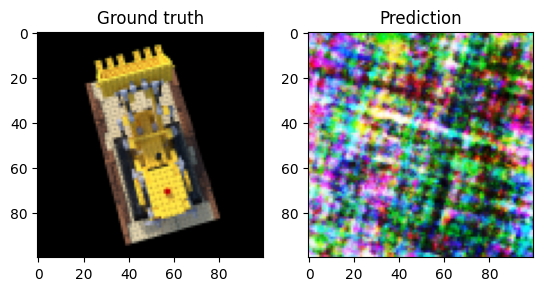

In [11]:
index = 100
with torch.no_grad():
    x = get_rays(H, W, focal, torch.tensor(poses[index]), near, far, num_samples, emb_dim).unsqueeze(0).to(device)
    pred_img = F.sigmoid(model(x)).squeeze(0).permute(2, 1, 0)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(imgs[index])
ax[0].set_title("Ground truth")
ax[1].imshow(pred_img.cpu())
ax[1].set_title("Prediction")

In [12]:
x.shape

torch.Size([1, 624, 100, 100])

In [182]:
torch.save(model, "tiny_nelf.pt")

In [188]:
torch.onnx.export(model.cpu(), x.cpu(), "nelf.onnx", opset_version=16)

In [59]:
h, w, f = 100, 100, 138
near, far = 2, 6
num_samples = 16
emb_dim = 6
pose = torch.tensor([
    [-9.9990219e-01,  4.1922452e-03, -1.3345719e-02, -5.3798322e-02],
    [-1.3988681e-02, -2.9965907e-01,  9.5394367e-01,  3.8454704e+00],
    [-4.6566129e-10,  9.5403719e-01,  2.9968831e-01,  1.2080823e+00],
    [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]
])

rayo, rayd = get_ray_origin_dir(h, w, f, pose)
print(rayd)
depths = torch.linspace(near, far, num_samples).view(-1, 1, 1)
rays = rayo + (rayd.unsqueeze(0) * depths.view(-1, 1, 1, 1))
rays = rays.reshape(-1, h, w)
rays = encode_pos(rays, emb_dim)
print(rays.shape)

tensor([[[ 0.3771,  0.3699,  0.3627,  ..., -0.3257, -0.3329, -0.3402],
         [ 0.3771,  0.3699,  0.3626,  ..., -0.3257, -0.3330, -0.3402],
         [ 0.3771,  0.3698,  0.3626,  ..., -0.3257, -0.3330, -0.3402],
         ...,
         [ 0.3742,  0.3670,  0.3597,  ..., -0.3286, -0.3359, -0.3431],
         [ 0.3742,  0.3669,  0.3597,  ..., -0.3287, -0.3359, -0.3432],
         [ 0.3741,  0.3669,  0.3596,  ..., -0.3287, -0.3359, -0.3432]],

        [[-1.0574, -1.0575, -1.0577,  ..., -1.0673, -1.0674, -1.0675],
         [-1.0553, -1.0554, -1.0555,  ..., -1.0651, -1.0652, -1.0653],
         [-1.0531, -1.0532, -1.0533,  ..., -1.0629, -1.0630, -1.0631],
         ...,
         [-0.8468, -0.8469, -0.8470,  ..., -0.8567, -0.8568, -0.8569],
         [-0.8446, -0.8447, -0.8448,  ..., -0.8545, -0.8546, -0.8547],
         [-0.8425, -0.8426, -0.8427,  ..., -0.8523, -0.8524, -0.8525]],

        [[ 0.0460,  0.0460,  0.0460,  ...,  0.0460,  0.0460,  0.0460],
         [ 0.0391,  0.0391,  0.0391,  ...,  0

In [74]:
import onnxruntime
ort_session = onnxruntime.InferenceSession(
    "nelf.onnx", providers=["CPUExecutionProvider"])
ort_inputs = {ort_session.get_inputs()[0].name: rays.unsqueeze(0).numpy()}
print(ort_inputs[list(ort_inputs.keys())[0]][0, :, 0:4, 0:4])
ort_outs = ort_session.run(None, ort_inputs)
print(ort_outs[0][0, :, :4, :4])

[[[ 7.00497806e-01  6.86006486e-01  6.71515107e-01  6.57023787e-01]
  [ 7.00437009e-01  6.85945690e-01  6.71454310e-01  6.56962991e-01]
  [ 7.00376272e-01  6.85884953e-01  6.71393573e-01  6.56902254e-01]
  [ 7.00315535e-01  6.85824215e-01  6.71332836e-01  6.56841516e-01]]

 [[ 1.73057556e+00  1.73037291e+00  1.73017001e+00  1.72996736e+00]
  [ 1.73491836e+00  1.73471570e+00  1.73451304e+00  1.73431015e+00]
  [ 1.73926139e+00  1.73905849e+00  1.73885584e+00  1.73865318e+00]
  [ 1.74360418e+00  1.74340153e+00  1.74319887e+00  1.74299598e+00]]

 [[ 1.30003703e+00  1.30003703e+00  1.30003703e+00  1.30003703e+00]
  [ 1.28621030e+00  1.28621030e+00  1.28621030e+00  1.28621030e+00]
  [ 1.27238369e+00  1.27238369e+00  1.27238369e+00  1.27238369e+00]
  [ 1.25855708e+00  1.25855708e+00  1.25855708e+00  1.25855708e+00]]

 ...

 [[-5.04509453e-03  9.82996047e-01  3.56292307e-01 -8.55683386e-01]
  [ 7.91370752e-04  9.84050989e-01  3.50832790e-01 -8.58689129e-01]
  [ 6.62780926e-03  9.85071182e-01  